In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
import warnings

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
asset_pool=['I','RB','ZN','AL','NI','CU','J','JM','WH','ZC','Y','TA','SR','RU','RM','P','M','C','PB','HC']

In [4]:
df_all=pd.DataFrame(columns=['update_date'])
for item in asset_pool:
    csv_path='%sFI_0112.csv'%item
    tmp=pd.read_csv(csv_path,encoding='gbk')
    tmp['update_date']=pd.to_datetime(tmp['update_date'])
    tmp=tmp.rename(columns={'close':item})
    df_all=pd.merge(df_all,tmp[['update_date',item]],on=['update_date'],how='outer')
    print item,np.max(tmp['update_date'])

I 2017-01-13 00:00:00
RB 2017-01-12 00:00:00
ZN 2017-01-12 00:00:00
AL 2017-01-13 00:00:00
NI 2017-01-16 00:00:00
CU 2017-01-13 00:00:00
J 2017-02-20 00:00:00
JM 2017-02-20 00:00:00
WH 2017-01-16 00:00:00
ZC 2017-02-20 00:00:00
Y 2017-01-16 00:00:00
TA 2017-01-16 00:00:00
SR 2017-01-16 00:00:00
RU 2017-01-16 00:00:00
RM 2017-01-16 00:00:00
P 2017-01-16 00:00:00
M 2017-01-16 00:00:00
C 2017-01-16 00:00:00
PB 2017-01-12 00:00:00
HC 2017-02-20 00:00:00


In [5]:
df_all=df_all.sort_values(by='update_date')
df_all=df_all.fillna(method='ffill')

In [6]:
#strategy_style: 1 means 'mean_reversion', 2 means 'trend_following'
def pair_trading(df_all,comp_list,period,strategy_style):
    if type(comp_list)==list:
        if len(comp_list)==2:
            df=df_all[['update_date',comp_list[0],comp_list[1]]]
            df['ratio']=df[comp_list[0]]/df[comp_list[1]]
            df['ratio_rolling_max']=pd.rolling_max(df['ratio'],period)
            df['ratio_rolling_min']=pd.rolling_min(df['ratio'],period)
            df['ratio_rolling_max']=df['ratio_rolling_max'].shift(1)
            df['ratio_rolling_min']=df['ratio_rolling_min'].shift(1)
            def compare(p,pmax,pmin):
                if p>pmax:
                    return 1
                elif p<pmin:
                    return -1
                else:
                    return np.nan
            df['signal']=map(compare,df['ratio'],df['ratio_rolling_max'],df['ratio_rolling_min'])
            df['signal']=df['signal'].shift(2)
            df['signal']=df['signal'].fillna(method='ffill')
            df['rr_1']=np.log(df[comp_list[0]])
            df['rr_1']=df['rr_1'].diff()
            df['rr_2']=np.log(df[comp_list[1]])
            df['rr_2']=df['rr_2'].diff()
            if strategy_style==1:
                df['daily_return_1']=0.5*df['rr_1']*(-1*df['signal'])
                df['daily_return_2']=0.5*df['rr_2']*(1*df['signal'])
            elif strategy_style==2:
                df['daily_return_1']=0.5*df['rr_1']*(1*df['signal'])
                df['daily_return_2']=0.5*df['rr_2']*(-1*df['signal'])
            df['daily_return']=df['daily_return_1']+df['daily_return_2']
            df['cum_return']=df['daily_return'].cumsum()
            df['std_ratio']=pd.rolling_std(df['ratio'],period)
            df.index=[df['update_date']]
            plt.figure(figsize=(15,3))
            plt.plot(df.index,df['cum_return'])
            ax2=plt.twinx()
            ax2.plot(df.index,df['ratio'],color='red',label='close',alpha=0.4)
#             ax2.plot(df.index,df['std_ratio'],color='orange',alpha=0.5)
#             ax3=ax2.twinx()
#             ax3.bar(df.index,df['std_ratio'],color='green',alpha=0.3)
            return df
        else:
            pass
#             return None
    else:
        pass
#         return None

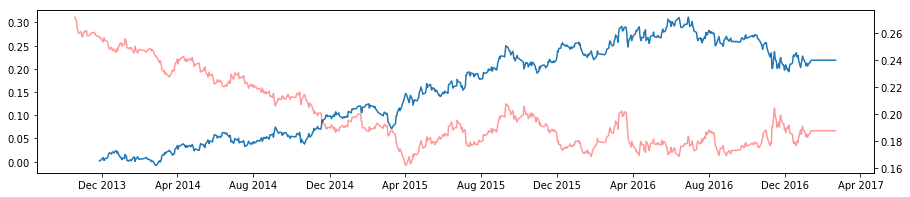

In [7]:
x1=pair_trading(df_all,['I','RB'],10,2)

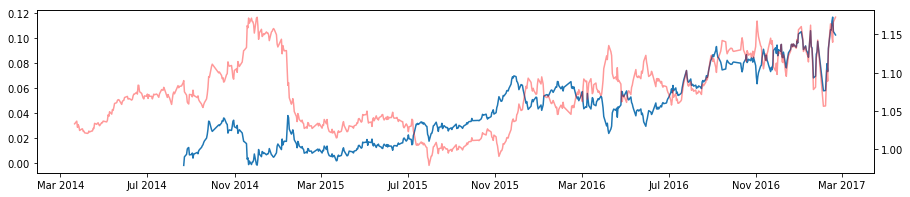

In [8]:
x2=pair_trading(df_all,['HC','RB'],60,1)

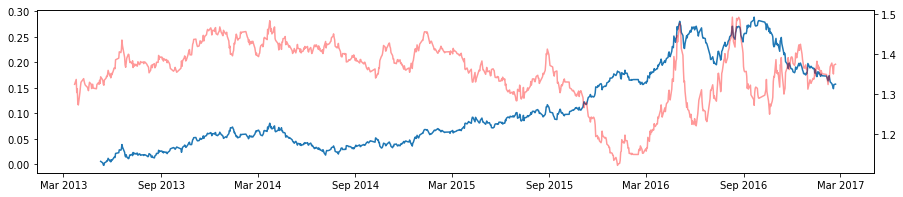

In [9]:
x3=pair_trading(df_all,['J','JM'],10,2)

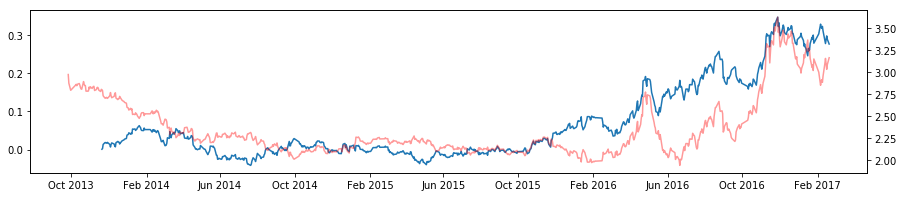

In [10]:
x4=pair_trading(df_all,['J','ZC'],20,2)

In [11]:
x_all=pd.concat([x1[['daily_return']],x2[['daily_return']],x3[['daily_return']],x4[['daily_return']]],axis=1,join='outer')

In [12]:
x_all=x_all.dropna(axis=0)

In [13]:
x_all.columns=['x1','x2','x3','x4']

In [14]:
x_all['mean_return']=(x_all['x1']+x_all['x2']+x_all['x3']+x_all['x4'])/4.

In [15]:
x_all['cum_return']=x_all['mean_return'].cumsum()

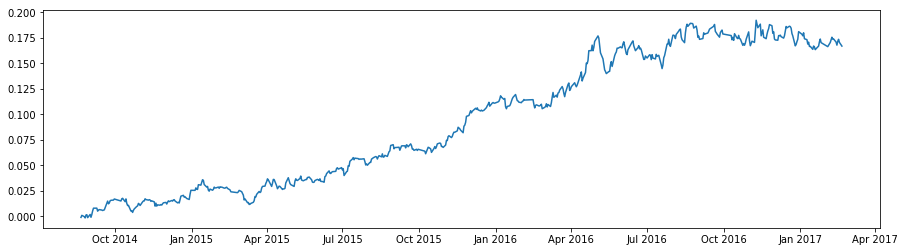

In [16]:
plt.figure(figsize=(15,4))
plt.plot(x_all['cum_return']);

[cu,al],[cu,zn],[cu,ni],[pb,zn]

In [17]:
####有色####

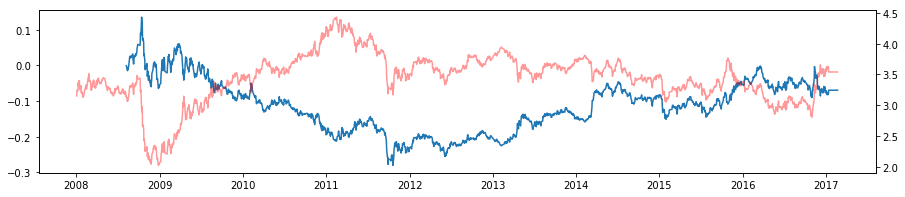

In [18]:
x5=pair_trading(df_all,['CU','AL'],100,1)

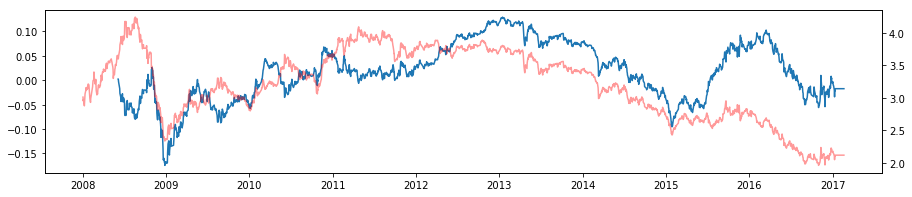

In [19]:
x6=pair_trading(df_all,['CU','ZN'],100,1)

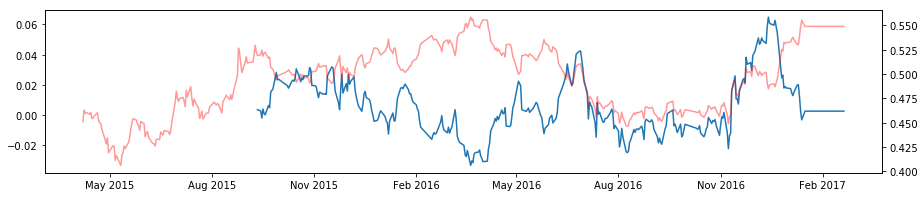

In [20]:
x7=pair_trading(df_all,['CU','NI'],100,1)

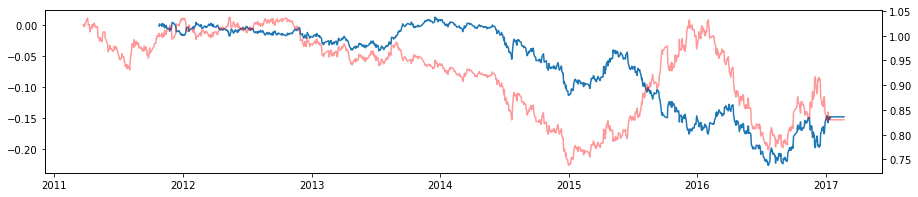

In [21]:
x8=pair_trading(df_all,['PB','ZN'],100,1)

In [22]:
x_youse=pd.concat([x5[['daily_return']],x6[['daily_return']],x7[['daily_return']],x8[['daily_return']]],axis=1,join='outer')

In [23]:
x_youse=x_youse.dropna(axis=0)

In [24]:
x_youse['mean_return']=x_youse.mean(axis=1)

In [25]:
x_all=pd.concat([x_all,x_youse],axis=1,join='inner')

In [26]:
x_all=x_all[['mean_return']]

In [27]:
x_all['daily_return']=x_all.mean(axis=1)

In [28]:
x_all['cum_return']=x_all['daily_return'].cumsum()

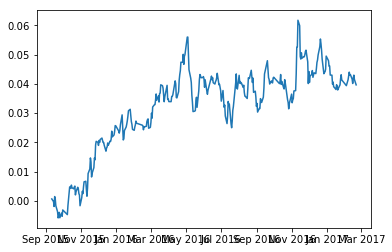

In [29]:
plt.plot(x_all['cum_return'])

In [30]:
x_youse['cum_return']=x_youse['mean_return'].cumsum()

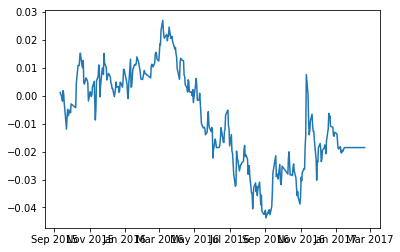

In [31]:
plt.plot(x_youse['cum_return'])

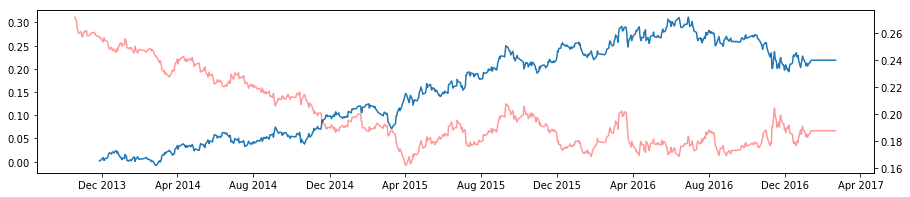

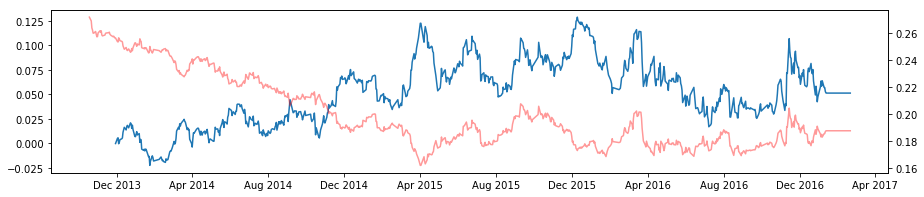

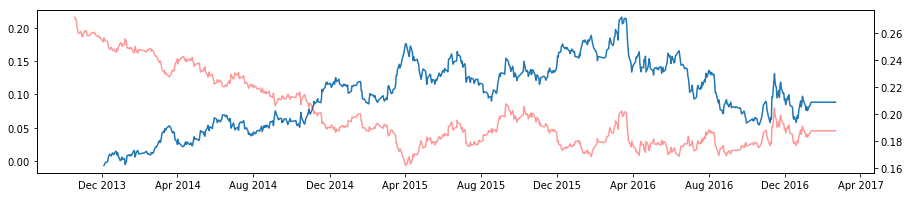

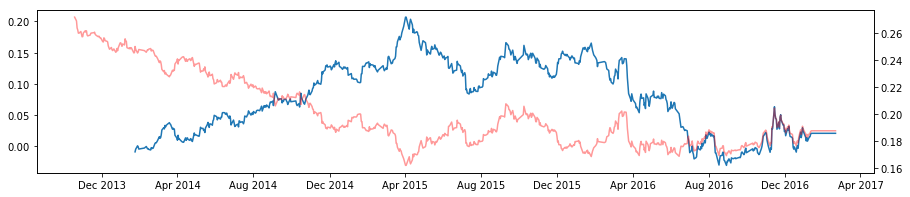

In [32]:
period_pool=[10,20,30,60]
# pair_pool=[['I','RB'],['HC','RB'],['J','JM'],['J','ZC']]
pair_pool=[['I','RB']]

pair_dict={"['I', 'RB']":2,"['HC', 'RB']":1,"['J', 'JM']":2,"['J', 'ZC']":2}

tot_df=pd.DataFrame()
for pair in pair_pool:
    tmp=pd.DataFrame(columns=['update_date'])
    for item in period_pool:
        x=pair_trading(df_all,pair,item,pair_dict[str(pair)])
        x=x[['update_date','daily_return']]
        if item==period_pool[0]:
            x['daily_return']=0.4*x['daily_return']
        elif item==period_pool[1]:
            x['daily_return']=0.3*x['daily_return']
        elif item==period_pool[2]:
            x['daily_return']=0.2*x['daily_return']
        elif item==period_pool[3]:
            x['daily_return']=0.1*x['daily_return']
        tmp.index=[tmp['update_date']]
        tmp=tmp.drop(['update_date'],axis=1)
        tmp=pd.concat([tmp,x],axis=1,join='outer')
    tmp['mean_return']=tmp.mean(axis=1)
    tmp=tmp[['mean_return']]
    tot_df=pd.concat([tot_df,tmp],axis=1,join='outer')

In [33]:
tot_df['daily_return']=tot_df.mean(axis=1)

In [34]:
tot_df=tot_df[['daily_return']]
tot_df=tot_df.dropna(axis=0)

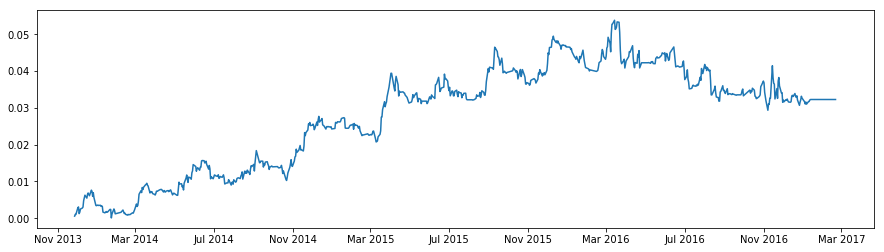

In [35]:
tot_df['cum_return']=tot_df['daily_return'].cumsum()
plt.figure(figsize=(15,4))
plt.plot(tot_df['cum_return'])

In [36]:
(np.mean(tot_df['daily_return'])*252-0.03)/(np.std(tot_df['daily_return'])*np.sqrt(252))

-1.0593397320479412

In [37]:
pair_dict.keys()

["['I', 'RB']", "['HC', 'RB']", "['J', 'ZC']", "['J', 'JM']"]

In [38]:
x

,update_date,daily_return
2008-01-02,2008-01-02,NaN
2008-01-03,2008-01-03,NaN
2008-01-04,2008-01-04,NaN
2008-01-07,2008-01-07,NaN
2008-01-08,2008-01-08,NaN
2008-01-09,2008-01-09,NaN
2008-01-10,2008-01-10,NaN
2008-01-11,2008-01-11,NaN
2008-01-14,2008-01-14,NaN
2008-01-15,2008-01-15,NaN
